In [1]:
# 卷积神经网络 激活函数使用selu
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.4
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.6.4
keras.api._v2.keras 2.6.0


In [2]:
!nvidia-smi

Tue Jul 26 09:26:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                              padding='same',
                              activation='relu',
                              input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

2022-07-26 09:26:46.010808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 09:26:46.153756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 09:26:46.154719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 09:26:46.156196: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [7]:
logdir = './cnn-selu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3), ]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks=callbacks)

2022-07-26 09:26:49.005185: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-26 09:26:49.005629: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-07-26 09:26:49.007713: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-07-26 09:26:49.281965: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-26 09:26:49.282156: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-07-26 09:26:49.803838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-07-26 09:26:51.138721: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


   1/1719 [..............................] - ETA: 3:38:28 - loss: 2.3085 - accuracy: 0.0000e+00

2022-07-26 09:26:57.517849: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-26 09:26:57.517912: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/1719 [..............................] - ETA: 11:33 - loss: 2.3043 - accuracy: 0.0156      

2022-07-26 09:26:57.893062: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-26 09:26:57.893707: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-07-26 09:26:58.035913: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 189 callback api events and 186 activity events. 
2022-07-26 09:26:58.045733: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-26 09:26:58.061766: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./cnn-selu-callbacks/train/plugins/profile/2022_07_26_09_26_58

2022-07-26 09:26:58.067164: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./cnn-selu-callbacks/train/plugins/profile/2022_07_26_09_26_58/5318ad39d7b3.trace.json.gz
2022-07-26 09:26:58.090032: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Cre

1719/1719 [==============================] - 17s 6ms/step - loss: 0.7410 - accuracy: 0.7327 - val_loss: 0.4215 - val_accuracy: 0.8504
Epoch 2/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4073 - accuracy: 0.8492 - val_loss: 0.3680 - val_accuracy: 0.8646
Epoch 3/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3463 - accuracy: 0.8721 - val_loss: 0.3199 - val_accuracy: 0.8820
Epoch 4/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3124 - accuracy: 0.8838 - val_loss: 0.3113 - val_accuracy: 0.8864
Epoch 5/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2875 - accuracy: 0.8936 - val_loss: 0.3010 - val_accuracy: 0.8922
Epoch 6/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2665 - accuracy: 0.9013 - val_loss: 0.2659 - val_accuracy: 0.9036
Epoch 7/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2495 - accuracy: 0.9081 - val_loss: 0.2659 - val_accuracy: 0.9

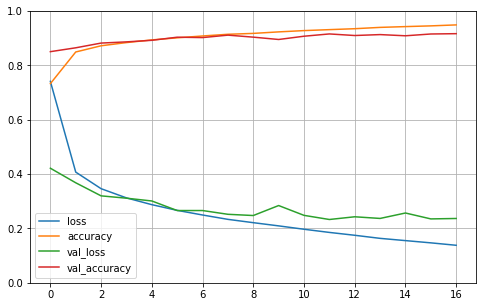

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [9]:
print(model.evaluate(x_test_scaled, y_test, verbose=0))

[0.26400718092918396, 0.9089000225067139]
